# Twitter Sentiment Analysis: Classifying Hate Speech (Pt II)

The goal for this project is to build a model that will allow us to detect hate speech in tweets. In this case a tweet is classified as hate speech if it contains racist or sexist remarks.

All data for this project is sourced from: https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/. Inspiration and some code for this project has been taken from:
- 'Stemming - Natural Language Processing With Python and NLTK p.3'- https://www.youtube.com/watch?v=yGKTphqxR9Q
- https://datascienceplus.com/twitter-analysis-with-python/
- Ultimate guide to deal with Text Data (using Python) – for Data Scientists & Engineers https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
- 'Deep Learning tutorials in jupyter notebooks.' - https://github.com/sachinruk/deepschool.io
- 'Text Classification Using CNN, LSTM and visualize Word Embeddings' - https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-visualize-word-embeddings-part-2-ca137a42a97d
- Tensor Flow: Embeddings Guide - https://www.tensorflow.org/guide/embedding
- Comparing scikit-learn text classifiers https://blog.kjamistan.com/comparing-scikit-learn-text-classifiers-on-a-fake-news-dataset/
- Understanding LSTM Networks - http://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Section 1: Setup ##
The data set we will be using to train our model consists of 31962 labelled tweets. Each row is 3-tuple (id, label, tweet). A label of 1 means the tweet is hate speech, a label of 0 is a normal tweet. 

In [6]:
import pandas as pd
import numpy as np
import nltk
from textblob import Word

df = pd.read_csv('./train_E6oV3lV.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
df.shape

(31962, 3)

The first step is to prepare the data using the data cleaning techniques implemented in stage 1 as well as a few new steps. These include:
- transform all tweet text to be lower case
- remove punctuation
- clean white space
- remove urls
- lemmatization
- 
For a full explanation of these techniques & their applicablity to improving the classification task please refer to the notebook from part 1.

In [7]:
# transform to lower case
df.tweet = df.tweet.apply(lambda x: " ".join(x.lower() for x in x.split()))
df.tweet.head()

# remove punctuation
df.tweet = df.tweet.str.replace('[^\w\s]','')

# remove urls
df.tweet = df.tweet.str.replace(r'http[\w:/\.]+','') 

df.tweet = df.tweet.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.tweet = df.tweet.str.replace(r'\.',' .')   #replace multple periods with a single one
df.tweet = df.tweet.str.replace(r'\s\s+',' ') #replace multple white space with a single one


# lemmatization
df.tweet = df.tweet.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df.tweet = df.tweet.str.strip() 
df.head()


,id,label,tweet
0,1,0,user when a father is dysfunctional and is so ...
1,2,0,user user thanks for lyft credit i cant use ca...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in urð...
4,5,0,factsguide society now motivation


To quantify the reliability of our classification model we will use the **F1 Score** described below:

**True Positives (TP)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

**True Negatives (TN)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

**False Positives (FP)** – When actual class is no and predicted class is yes.

**False Negatives (FN)** – When actual class is yes but predicted class in no.

**Precision** = TP/TP+FP

**Recall** = TP/TP+FN

**F1 Score** = 2*(Recall * Precision) / (Recall + Precision)
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

![title](precision_recall.png) https://en.wikipedia.org/wiki/F1_score

## Section 2: Approach ##
In Stage 1 of our sentiment analysis project we built a simple model by counting the frequencies of every word as they occur in each tweet. This is known as the 'bag-of-words' (BoW) method in in Natural Language rocessing (NLP). We can think of the bag-of-words as representing each tweet as a multiset, or alternatively a vector. While this feature is relatively simple to extract, for stage 2 we will employ a more sophisticated approach using a specific type of Recurring Neural Net (RNN) known as a Long Short Term Memory network (LSTM). 

Compared with the 'bag-of-words' approach the LSTM model can take into account sentence structure. Where the BoW method considers only how many times a particular word occurs in tweet, the LSTM model can take into account word order through using a chain like structure of cell states.
<br><br>
![The repeating module in an LSTM contains four interacting layers.](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
<br>
<center><b> The repeating module of a simple unrolled LSTM containing four interacting layers.</b></center>
<br>
As the network encounters new pieces of information the these layers decides how much information is carried forward or let through, and how much is added. Each LSTM cell takes an input vector and the hidden output vector of the previous cell and produces an output vector and the hidden output vector for the next cell. 

#### Using multiple models for binary classification
We will benchmark this LSTM model against the model from stage 1 and also against a model using Multinomial Naive Bayes With Tf-Idf Vectors, as well as a Support Vector Machine (SVM) model with balanced class weights.

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import re

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from keras.models import load_model, model_from_json

from sklearn.model_selection import train_test_split

import os
import urllib

from collections import Counter

https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras

In [17]:
df.tweet.values[0]

'user when a father is dysfunctional and is so selfish he drag his kid into his dysfunction run'

We get all the unique words from each tweet. We will only consider words that are used more than 4 times. From this we create a dictionary mapping words to integers.

From there we will create a list of tweets with all the words converted to ints.

In [18]:
all_text = ' '.join(df.tweet.values)
words = all_text.split()
u_words = Counter(words).most_common()
u_words = [word[0] for word in u_words if word[1]>4] # we will only consider words that have been used more than 5 times
# create the dictionary
word2num = dict(zip(u_words,range(len(u_words))))
word2num['<Other>'] = len(u_words)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else len(u_words) for word in Review.split()] for Review in df.tweet.values]

print('The number of unique words are: ', len(u_words))
print('The first tweet looks like this: ')
print(int_text[0][:20])

The number of unique words are:  6108
The first tweet looks like this: 
[0, 35, 3, 55, 9, 6108, 6, 9, 20, 3166, 82, 3421, 100, 205, 264, 100, 6108, 436]


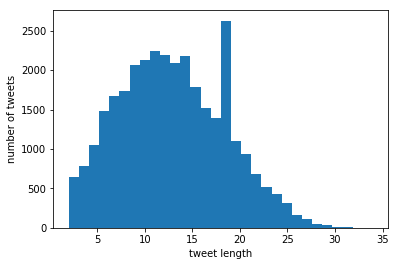

In [19]:
plt.hist([len(t) for t in int_text],30)
plt.xlabel('tweet length')
plt.ylabel('number of tweets')
plt.show()

We will use a many to one LSTM

In [27]:
print('The number of tweets greater than 25 in length is: ', np.sum(np.array([len(t)>25 for t in int_text])))

The number of tweets greater than 25 in length is:  380


You cannot pass differing lengths of sentences to the algorithm. Hence we shall prepad the sentence with <PAD>. Sequences less than 25 in length will be prepadded and sequences that are longer than 25 will be truncated. We assume that 25 characters will be sufficient to classify the sentiment.

In [59]:
num2word[len(word2num)] = '<PAD>'
word2num['<PAD>'] = len(word2num)

for i, t in enumerate(int_text):
    if len(t)<25:
        int_text[i] = [word2num['<PAD>']]*(25-len(t)) + t
    elif len(t)>25:
        int_text[i] = t[:25]
    else:
        continue

x = np.array(int_text)
y = df.label.values

# split data for train/test crossover
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

#### Many To One LSTM
For this model we will use a many to one LSTM. We will use the adam optimization algorithm for deep learning which is derived from adaptive moment estmation. It is an extenison to stochastic gradient descent. 

In [60]:
model = Sequential()
model.add(Embedding(len(word2num), 32)) # , batch_size=batch_size
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          195520    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 220,417
Trainable params: 220,417
Non-trainable params: 0
_________________________________________________________________


In [61]:
X_train.shape

(28765, 25)

In [62]:
batch_size = 128 
model.fit(X_train, y_train, batch_size=batch_size, epochs=2)

Epoch 1/2
28765/28765 [==============================] - 7s 227us/step - loss: 0.2270 - acc: 0.9331
Epoch 2/2
28765/28765 [==============================] - 7s 239us/step - loss: 0.1021 - acc: 0.9628


The first value below is the loss rate, while the second value is the accuracy metric calculated by keras.

In [24]:
model.evaluate(X_test, y_test, batch_size=batch_size)

3197/3197 [==============================] - 0s 76us/step


[0.1181278051595819, 0.9587112926937171]

The model we've built seems promising, showing high accuracy using the split training data. Lets calculate the F1 score over our test split with sci-kit.

In [29]:
print(classification_report(y_test, np.round(model.predict(X_test))))
y_test.shape

             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2984
          1       0.74      0.58      0.65       213

avg / total       0.96      0.96      0.96      3197



(3197,)

The prediction for a single tweet looks like this

In [59]:
X_test[0,:]

array([6109, 6109, 6109, 6109, 6109, 6109, 6109,    0, 6108,  377,  150,
         12,   68,    9, 6108,    4,  150,   27, 6108, 6108, 6108,   68,
        148, 4028, 4028])

In [60]:
model.predict(X_test[0][None,:])

array([[0.00049756]], dtype=float32)

In [61]:
y_test[0]

0

Lets try building other models for comparison.

#### Multinomial Naive Bayes With Tf-Idf Vectors & SVM with balanced class weights
For these models we will use a 3-way training split and use grid search for parameter tuning.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(df.tweet, df.label, test_size=0.33,
                                                    random_state=5)

# Pipeline for multinomial naive Bayes
mnb = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())
               ])


# Pipeline for polynomial support vector machine with balanced class weights
svm = Pipeline([('vect', CountVectorizer(lowercase=False)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC(C=0.1, penalty='l2', class_weight='balanced'))
               ])

# Grid search parameters
param_grid = [{'vect__binary': [True],
               'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': [True, False]
              },
              {'vect__binary': [False],
               'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': [True, False]
              }
             ]

# Find best parameters for MNB
gs_mnb = GridSearchCV(mnb, param_grid)
gs_mnb.fit(X_train, y_train)
print('\nMNB best params:\n', gs_mnb.best_params_)

# Find best parameters for SVM
gs_svm = GridSearchCV(svm, param_grid)
gs_svm.fit(X_train, y_train)
print('\nSVM best params:\n', gs_svm.best_params_)

# Print accuracy
print('\nMNB test result:\n', classification_report(y_test, gs_mnb.predict(X_test)))
print('\nSVM test result:\n', classification_report(y_test, gs_svm.predict(X_test)))


MNB best params:
 {'tfidf__use_idf': True, 'vect__binary': True, 'vect__ngram_range': (1, 2)}

SVM best params:
 {'tfidf__use_idf': True, 'vect__binary': True, 'vect__ngram_range': (1, 2)}

MNB test result:
              precision    recall  f1-score   support

          0       0.94      1.00      0.97      9793
          1       1.00      0.11      0.19       755

avg / total       0.94      0.94      0.91     10548


SVM test result:
              precision    recall  f1-score   support

          0       0.98      0.96      0.97      9793
          1       0.58      0.75      0.66       755

avg / total       0.95      0.94      0.95     10548



## Section 3: Comparing Results
The results from MNB and SVM seem quite accurate, although not as accurate as the LSTM network. We will compare the F1-scores and confusion matrix for each model.

In [55]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Classification report for LSTM

             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2984
          1       0.77      0.58      0.66       213

avg / total       0.96      0.96      0.96      3197



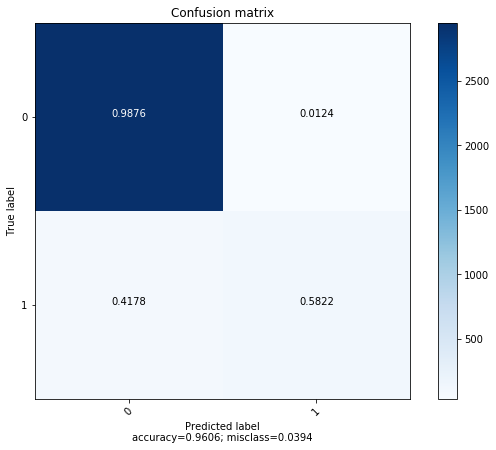

In [63]:
from sklearn import metrics
pred = np.round(model.predict(X_test))
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
print('Classification report for LSTM\n')
print(classification_report(y_test, np.round(model.predict(X_test))))

plot_confusion_matrix(cm, [0,1])

Classification report for MNB

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      9793
          1       1.00      0.11      0.19       755

avg / total       0.94      0.94      0.91     10548



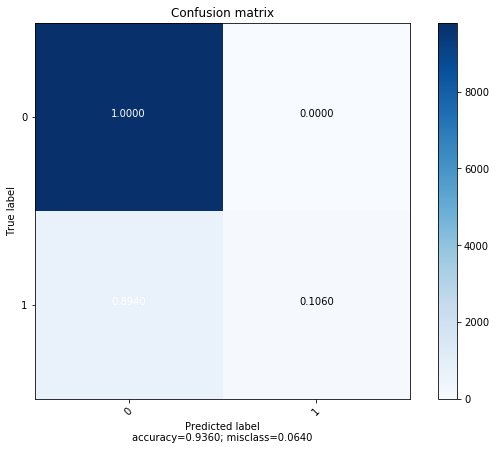

In [57]:
pred = gs_mnb.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
print('Classification report for MNB\n')
print(classification_report(y_test, pred))

plot_confusion_matrix(cm, [0,1])

Classification report for SVM

             precision    recall  f1-score   support

          0       0.98      0.96      0.97      9793
          1       0.58      0.75      0.66       755

avg / total       0.95      0.94      0.95     10548



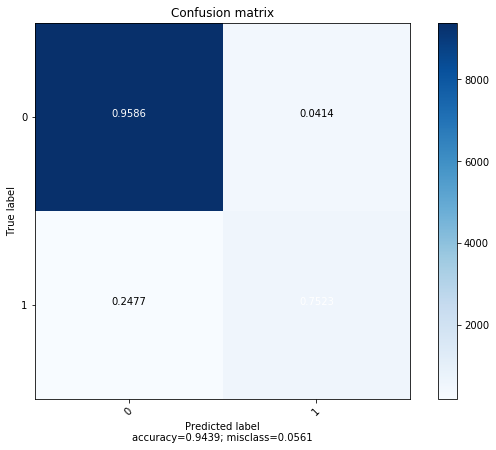

In [54]:
pred = gs_svm.predict(X_test)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
print('Classification report for SVM\n')
print(classification_report(y_test, pred))

plot_confusion_matrix(cm, [0,1])

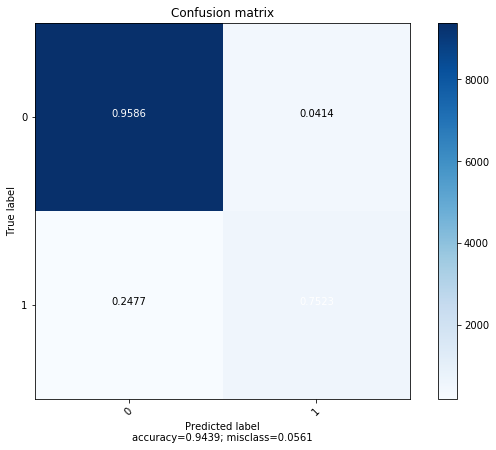

In [53]:
plot_confusion_matrix(cm, [0,1])

In order of performance (F1-score) we see that LSTM performed best, followed by SVM followed by MNB. 

From the classification report and confusion matrices we can see that precision for non-hate speech was high (TP/(TP+FP)), with normal tweets rarely being misclassified as hate speech. However recall for hate speech tweets is quite low, (0.58 for LSTM, 0.11 for MNB & 0.75 for SVM).

This fact highlights how accuracy alone can be misleading when evaluating a model 

In [72]:
pred = gs_svm.predict(X_test).decode('utf-8')
curve = metrics.roc_curve(y_test, pred)
plt.plot(curve)
plt.show()

TypeError: cannot use a string pattern on a bytes-like object

In [66]:
print(curve

(array([0.        , 0.01239946, 1.        ]), array([0.        , 0.58215962, 1.        ]), array([2., 1., 0.], dtype=float32))
